# 0 - MODULES

All modules, libraries, imports and constants used in this file

In [165]:
# LIBRARY IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# One off imports
from seaborn import heatmap
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


# CONSTANTS
INPUT_FILE_PATH = 'dataset.csv'
FIGURE_NAME = 'dataScatterPlot.png'

# 1 - DATA SET READING + PLOTTING


Load the synthetic dataset you have previously downloaded. This dataset has two features and a
class label. Use matplotlib’s scatter() function to plot the dataset on a 2D plane and color the
points based on their class label. How do you expect a decision tree to approach data distributed in
this way?

In [166]:
def readFile(file:str)->pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=file, header=0, dtype={'x0':float, 'x1':float, 'label':int})

def plotDf(df:pd.DataFrame, figPath:str=None)->None:
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.scatter(x=df['x0'], y=df['x1'], c=df['label'].apply(lambda x: 'red' if x else 'blue'))
    ax.set_ylabel(ylabel='x1 values', loc='center')
    ax.set_xlabel(xlabel='x0 values', loc='center')

    # To plot the legend
    """color_map = {0: 'blue', 1: 'red'}
    # Add a legend to explain the colors 
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[l], markersize=10) for l in color_map] 
    labels = color_map.keys() 
    ax.legend(handles, labels, title='Class')
    """
    if figPath:
        fig.savefig(figPath)
        
    plt.show()    
    
# NOTE: a decision tree will not work, the data are divided in an oblique way, decision tree work only well if the data
# are divided horizontally or vertically

# 2 - TREE BUILDING 


To show how not well it works:<br>
Build a “default” decision tree using the entire dataset, then visualize the learned model. What is
the tree learning, and why?

In [167]:
def buildTree(df:pd.DataFrame)->DecisionTreeClassifier:
    return DecisionTreeClassifier().fit(X=df[['x0', 'x1']], y=df['label'])

# As expected the tree is way to complex, with too may branches and too deep, it over fits our model

def partitionDataWithTraining(df: pd.DataFrame, testSize:float)->str:
    xTrain, xTest, yTrain, yTest = train_test_split(df.loc[:, ['x0','x1']], df['label'], test_size=testSize)
    tree = DecisionTreeClassifier().fit(xTrain, yTrain)
    mat = confusion_matrix(yTest, tree.predict(xTest))
    fig, ax = plt.subplots(1,2,figsize=(10, 7))
    
    ax[0].set_title('heatmap')
    heatmap(mat, annot=True, ax=ax[0])
    
    ax[1].set_title('decision tree')
    ax[1] = plot_tree(tree)
    plt.tight_layout()
    
    return f"Accuracy = {100*np.linalg.trace(mat)/np.sum(mat)}"
    

# 3 - PREPROCESSING

Identify a preprocessing step that would make the decision tree “correctly” approach this problem.

In [168]:
# Min max scaler and standard scaler won't work cause it just rescales does not modify the value general position

def dataPreprocessing(df:pd.DataFrame, graph:bool=False)->pd.DataFrame:
    df['x2'] = df['x1'] +df['x0']
    
    if graph:
        fig, ax = plt.subplots(figsize=(5,5))
        
        ax.scatter(x=10-df['x0'], y=df['x2'], c=df['label'].apply(lambda x: 'red' if x else 'blue'))
        ax.set_ylabel(ylabel='x1 values', loc='center')
        ax.set_xlabel(xlabel='x0 values', loc='center')
    
    return df


def quickComparison(df: pd.DataFrame, testSize:float=0.20, neighbors:int=20, saveFig:bool=False)->None:
    fig, ax = plt.subplots(2,3, figsize=(10,10))
    
    
    # USING x0 and x1
    xTrain, xTest, yTrain, yTest = train_test_split(df.loc[:, ['x0','x1']], df['label'], test_size=testSize)    
    ax[0,0].scatter(x=df['x0'], y=df['x1'], c=df['label'].apply(lambda x: 'red' if x else 'blue'))
    ax[0,0].set_xlabel(xlabel='x0 values', loc='center')
    ax[0,0].set_ylabel(ylabel='x1 values', loc='center')
    for i in range(2):
        ax[i,1].title.set_text('Decision Tree')
        ax[i,2].title.set_text('Knn')
    
    # using trees and knn on
    heatmap(confusion_matrix(yTest, DecisionTreeClassifier().fit(xTrain, yTrain).predict(xTest)), ax=ax[0,1], annot=True)
    heatmap(confusion_matrix(yTest, KNeighborsClassifier(neighbors).fit(xTrain, yTrain).predict(xTest)), ax=ax[0,2], annot=True)
    
    # USING x0 and x2
    xTrain, xTest, yTrain, yTest = train_test_split(df.loc[:, ['x0','x2']], df['label'], test_size=testSize)    
    ax[1,0].scatter(x=df['x0'], y=df['x2'], c=df['label'].apply(lambda x: 'red' if x else 'blue'))
    ax[1,0].set_xlabel(xlabel='x0 values', loc='center')
    ax[1,0].set_ylabel(ylabel='x2 values', loc='center')
    
    # using trees and knn on
    heatmap(confusion_matrix(yTest, DecisionTreeClassifier().fit(xTrain, yTrain).predict(xTest)), ax=ax[1,1], annot=True)
    heatmap(confusion_matrix(yTest, KNeighborsClassifier(neighbors).fit(xTrain, yTrain).predict(xTest)), ax=ax[1,2], annot=True)
    
    plt.tight_layout()
    plt.show()    
    
    if saveFig:
        fig.savefig('quickModelComparison.png')

# 4 - PLOTTING THE DECISION BOUNDARIES

Sklearn’s decision trees store, for each split they do, the information about the feature they are
using for the split and the threshold value used in the comparison. <BR>
You can find this information in clf.tree_.feature and clf.tree_.threshold (the order of the elements in those arrays is the
one you get with a pre-order visit of the decision tree). With this information, plot the decision
boundaries (i.e. features’ thresholds) applied by the decision tree on the dataset. <BR>Ideally, you should
have a 2D scatter plot with vertical and horizontal lines that divide the plane into subregions (one for
each leaf of the tree). You can use matplotlib’s axvline and axhline to plot vertical and horizontal
lines in your plot.

In [169]:
def draw_split(features, thresholds, i, x0_min, x0_max, x1_min, x1_max, col:str='x1'):
    f, t = features[i], thresholds[i]
    if f == -2:
        # leaf node, return offset to be added
        # for the parent to visit the next child
        return 1 
    # draw the current split
    if f == 0: # vertical split (x0)
        plt.axvline(t, x1_min*.1, x1_max*.1)
        # prepare the new bounding boxes
        
        # from x0_min to threshold
        bb_left = (x0_min, t, x1_min, x1_max) 
        # from threshold to x0_max
        bb_right = (t, x0_max, x1_min, x1_max)
    else: # horizontal split (x1)
        plt.axhline(t, x0_min*.1, x0_max*.1)
        
        bb_left = (x0_min, x0_max, x1_min, t)
        bb_right = (x0_min, x0_max, t, x1_max)
    off_left = draw_split(features, thresholds, i+1, *bb_left)
    off_right = draw_split(features, thresholds, i+off_left+1, *bb_right)
    return off_right + off_left + 1

def plotBoundaries(df:pd.DataFrame, clf:DecisionTreeClassifier, col:str='x1')->None:
    plt.scatter(x=df['x0'], y=df[col], c=df['label'].apply(lambda x: 'red' if x else 'blue'))
    draw_split(clf.tree_.feature, clf.tree_.threshold, 0, 0, 10, 0, 10, col)
    plt.show()

# MAIN FUNCTION

This is the main function of the program that coordinates everything, it does:
<ol>
<li>The read of the file and the plotting of the points</li>
<li>Tries to build a tree to show how inefficient it is</li>
<li>Trying some data preprocessing</li>
<li>Visualizing data splitting</li>
</ol>

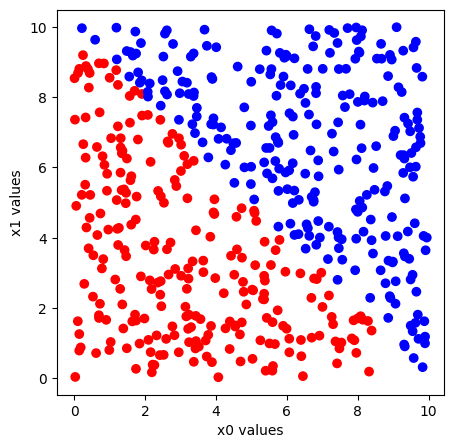

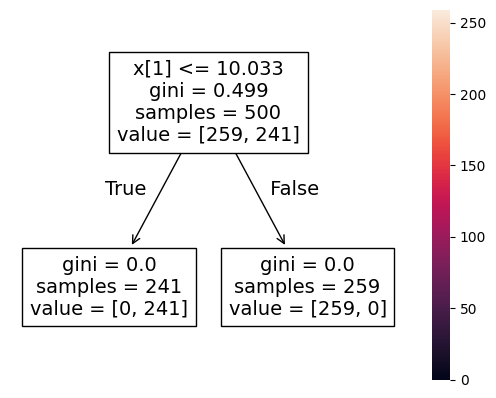

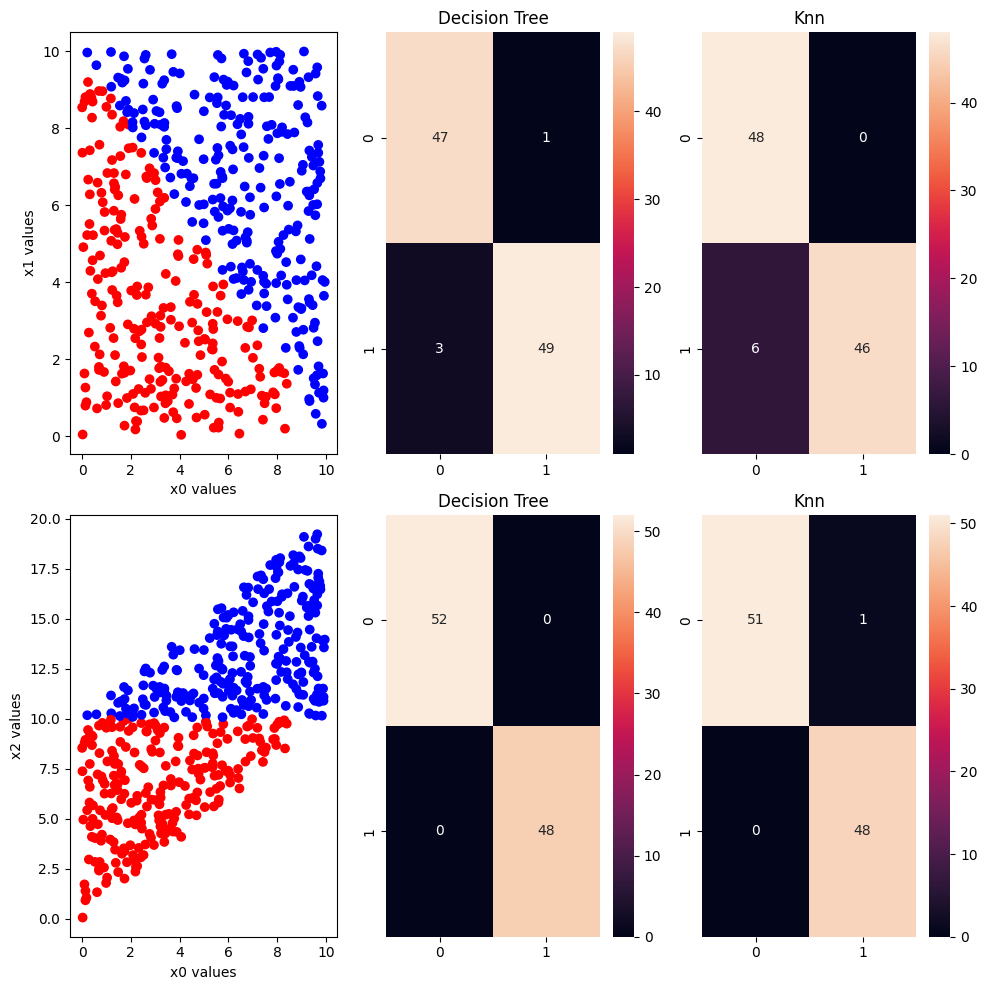

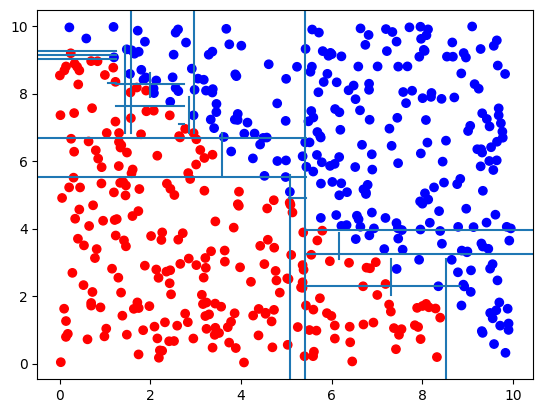

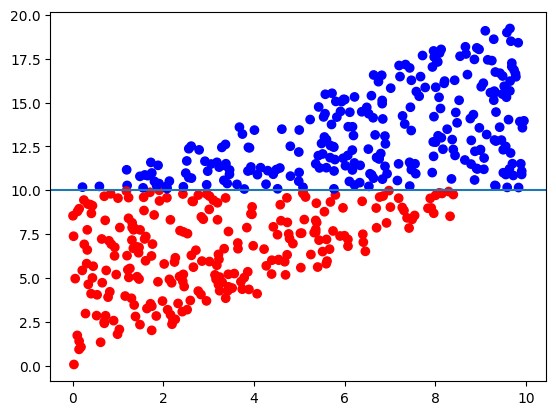

In [170]:
def main()->None:
    df = readFile(INPUT_FILE_PATH) # 1
    plotDf(df) # 1
    
    # 100 percent accuracy, it fucking over fits as expected
    tree = buildTree(df) # 2
    plot_tree(tree) # 2
    heatmap(confusion_matrix(df['label'], tree.predict(df[['x0', 'x1']])), annot=True) # 2
    # print(partitionDataWithTraining(df, 0.20)) # 2
    
    df = dataPreprocessing(df) # 3
    
    plot_tree(DecisionTreeClassifier().fit(df.loc[:, ['x0', 'x2']], df.loc[:, 'label'])) # 3 the tree is much simpler
    
    # trying a quick comparison with KNN
    quickComparison(df, saveFig=False) # 3
    
    # try also with x2 instead of x1
    plotBoundaries(df, DecisionTreeClassifier().fit(df.loc[:, ['x0', 'x1']], df.loc[:, 'label']), col='x1') # 4
    plotBoundaries(df, DecisionTreeClassifier().fit(df.loc[:, ['x0', 'x2']], df.loc[:, 'label']), col='x2') # 4
    
    
main()